# Import Modules

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import openpyxl
import datetime
from dateutil import parser

In [2]:
OPENAI_API_KEY = ""
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [3]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage

# User-Defined Functions

In [4]:
# Read Raw data downloded in excel format
def read_raw_data (excel_file_name: str) -> pd.DataFrame:
    try:
        df = pd.read_excel(
            excel_file,
            parse_dates=[0],           # Parse first column as datetime
            dtype={1: 'Int64'},        # Safely handle large integers
            engine='openpyxl',         # Use openpyxl for .xlsx files    
        )
        #print(df.head(5))
    
    except Exception as e:
        print("Error reading Excel file:", e)

    return df

In [5]:
# Function to get sentiment using LangChain
def get_sentiment_with_langchain (text: str) -> str:
    prompt = prompt_template.format(text=text)
    try:
        response = llm([HumanMessage(content=prompt)])
        return response.content.strip()
    except Exception as e:
        print("Error processing:", text, "\n", e)
        return "Error"

In [6]:
def compute_sentiments (df: pd.DataFrame, text_sentiment_map: dict) -> pd.DataFrame:
    for text_key in text_sentiment_map.keys():
        print(text_key, text_sentiment_map[text_key])
        df[text_sentiment_map[text_key]] = df[text_key].apply(get_sentiment_with_langchain)

    return df

In [128]:
def visualize_sentiments (df: pd.DataFrame, text_sentiment_map: dict, sentiment_colors: dict) -> None:
    sorted_sentiment_colors = dict(sorted(sentiment_colors.items()))
    num_text_types = len(text_sentiment_map.keys())
    fig, axes = plt.subplots(1, num_text_types, figsize=(12, 6))
    for sent_type_count, text_key in enumerate(text_sentiment_map.keys()):
        #print(text_key, text_sentiment_map[text_key])
        counts_sent = df[text_sentiment_map[text_key]].value_counts()
        counts_sent = counts_sent.reindex(sorted_sentiment_colors.keys())
        counts_colors = pd.DataFrame(counts_sent).fillna(0)
        counts_colors['colors'] = sorted_sentiment_colors.values()
        axes[sent_type_count].pie(counts_colors['count'], colors=counts_colors['colors'], labels=counts_colors.index, autopct="%1.1f%%", startangle=90)
        axes[sent_type_count].set_title(text_key)
        axes[sent_type_count].legend()
        
    
    plt.suptitle("Sentiment Distributions Across Text Columns", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [8]:
def reduce_df_to_a_sentiment (df_orig: pd.DataFrame, text_sentiment_map: dict, desired_sentiment: str) -> pd.DataFrame:
    df = df_orig.copy()
    for text_key in text_sentiment_map.keys():
        #print(text_key, text_sentiment_map[text_key])
        df = df [df[text_sentiment_map[text_key]] == desired_sentiment]

    return df
    

In [9]:
# Function to extract keywords and counts using OpenAI
def extract_keywords_with_counts(llm, prompt_template, text: str):
    prompt = prompt_template.format(text=text[:4000])  # truncate if needed
    response = llm([HumanMessage(content=prompt)])
    
    # Parse response into dict
    result = {}
    for line in response.content.strip().split("\n"):
        if ":" in line:
            try:
                key, val = line.split(":")
                result[key.strip()] = int(val.strip())
            except ValueError:
                continue
    return result

In [10]:
def extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, desired_sentiment, llm, prompt_template, freq_words_collection):
    # Reduce the data frame so that each text column has the same sentiment type
    #df = reduce_df_to_a_sentiment (df_orig, text_sentiment_map, desired_sentiment)
    
    for sent_type_count, text_key in enumerate(text_sentiment_map.keys()):
        #print(text_key, text_sentiment_map[text_key])
        df = df_orig [df_orig[text_sentiment_map[text_key]] == desired_sentiment]
        col = text_key
        text = " ".join(df[col].dropna().astype(str).tolist())
        result = extract_keywords_with_counts(llm, prompt_template, text)
        
        freq_words_collection[text_key][desired_sentiment] = result
    
        print(f"\nTop 10 keywords from column '{col}' that represent '{desired_sentiment}' sentiments:")
        for k, v in result.items():
            print(f"{k}: {v}")

    return freq_words_collection

In [71]:
def visualize_frequent_words_for_sentiment (freq_words_collection, sentiment_colors):

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), sharey=False)
    fig.suptitle("Top Keywords by Sentiment for Each Text Source", fontsize=16, fontweight='bold')
    
    for ax, (source, sentiments) in zip(axes, freq_words_collection.items()):
        ax.set_title(f"{source.replace('_', ' ').title()}")
        all_words = []
        all_counts = []
        all_colors = []
    
        for sentiment, words in sentiments.items():
            for word, count in words.items():
                all_words.append(word)
                all_counts.append(count)
                all_colors.append(sentiment_colors.get(sentiment, 'black'))
    
        # Plot histogram
        ax.barh(all_words, all_counts, color=all_colors)
        ax.invert_yaxis()  # Highest count at top
        ax.set_xlabel("Frequency")
        ax.set_ylabel("Words")
        ax.grid(axis='x', linestyle='--', alpha=0.7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [91]:
def visualize_sentiment_trend (grouped, time_type, text_key, sentiment_colors):
    fig, axes = plt.subplots(len(grouped.columns), 1, figsize=(10, 6), sharex=True)
    
    # Ensure axes is iterable
    if len(grouped.columns) == 1:
        axes = [axes]
    
    for i, sentiment in enumerate(grouped.columns):
        axes[i].plot(grouped.index, grouped[sentiment], marker='o', color = sentiment_colors.get(sentiment, 'black'))
        axes[i].set_title(f"Sentiment: {sentiment}")
        axes[i].set_ylabel("Count")
        axes[i].grid(True)
    
    plt.xlabel(time_type)
    plt.tight_layout()
    plt.suptitle(f"Sentiment Counts by {time_type} for {text_key}", fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Read the Raw Data

In [12]:
excel_file = 'engagements.xlsx'
df = read_raw_data(excel_file)
df.head(5)

,timestamp,media_id,media_caption,comment_text
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good
1,2025-03-01 00:23:06.879000+00:00,17950254656929862,Why use one scrub when you can use them all at...,i know this smells so good
2,2025-03-01 00:04:05.094000+00:00,1090109319826090,Morning routine with Tree Hut 🍊🫧 Now available...,Love it
3,2025-03-01 00:41:59.467000+00:00,1098364052333950,Why use one scrub when you can use them all at...,Please carry these in Canada! I miss them so m...
4,2025-03-01 02:21:29.715000+00:00,1083943630442659,Vanilla Serum-Infused Hand Wash: A sweet escap...,I love it ..✌️


# Proceed with a subset for Testing or if Constrained my OpenAI Limits

In [13]:
##
#n_rows = len(df)
df = df.iloc[::50]

In [14]:
len(df)

357

# Define LLM

In [15]:
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.0)

/tmp/ipykernel_1363272/1554941544.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0.0)


# Analyze Sentiments

In [69]:
sentiment_colors = {
    'Positive': 'green',
    'Neutral': 'gray',
    'Negative': 'red'
    }

### Define a prompt template

In [16]:
prompt_template = PromptTemplate.from_template(
    "Classify the sentiment of the following text as Positive, Negative, or Neutral:\n\n{text}\n\nSentiment:"
)

### Define a map between column names with text and the corresponding sentiment

In [17]:
text_sentiment_map = {
    'media_caption': 'sentiment_media_caption',
    'comment_text': 'sentiment_comment_text',
    #'comment_text2': 'sentiment_comment_text2'
}

In [18]:
text_sentiment_map

{'media_caption': 'sentiment_media_caption',
 'comment_text': 'sentiment_comment_text'}

In [19]:
#df['media_caption'][0]

In [20]:
#get_sentiment_with_langchain(df['media_caption'][0])

### Compute Sentiments

In [21]:
df = compute_sentiments (df, text_sentiment_map)
df_orig = df.copy()

media_caption sentiment_media_caption


/tmp/ipykernel_1363272/4098399969.py:5: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm([HumanMessage(content=prompt)])


comment_text sentiment_comment_text


In [126]:
df

,timestamp,media_id,media_caption,comment_text,sentiment_media_caption,sentiment_comment_text,Date,Hour,DayName
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Positive,2025-03-01,0,Saturday
50,2025-03-01 14:15:19.831000+00:00,1083080453862310,"If you’re seeing this, it’s time to exfoliate ⏰",Megan Brohm hello how are you doing today I ho...,Neutral,Neutral,2025-03-01,14,Saturday
100,2025-03-02 00:56:58.764000+00:00,1091594239677598,*slams laptop shut* ✌️🚿🌴 click the link to get...,Nicole Lee Walmart. I use the nighttime melato...,Positive,Positive,2025-03-02,0,Sunday
150,2025-03-02 22:31:31.547000+00:00,1095789242591431,Freshening up my self-care routine with a new ...,Donika Blaqstallion Anderson this what I use,Positive,Neutral,2025-03-02,22,Sunday
200,2025-03-03 20:29:41.342000+00:00,17842568505433586,Drop a 🪷 if you're obsessed with Lotus Water!,🪷,Positive,Neutral,2025-03-03,20,Monday
...,...,...,...,...,...,...,...,...,...
17600,2025-04-02 15:13:18.667000+00:00,1125861369584218,that's that me espresso,Ash Lee Jorhdan,Neutral,Neutral,2025-04-02,15,Wednesday
17650,2025-04-02 15:55:15.355000+00:00,1125861369584218,that's that me espresso,Ondrea Nordby,Neutral,Neutral,2025-04-02,15,Wednesday
17700,2025-04-02 16:30:53.153000+00:00,1125861369584218,that's that me espresso,Aliyah Skala I need this,Neutral,Neutral,2025-04-02,16,Wednesday
17750,2025-04-02 17:55:39.320000+00:00,1125861369584218,that's that me espresso,Savannah Rose O'Neil okay,Neutral,Neutral,2025-04-02,17,Wednesday


### Visualize Sentiments

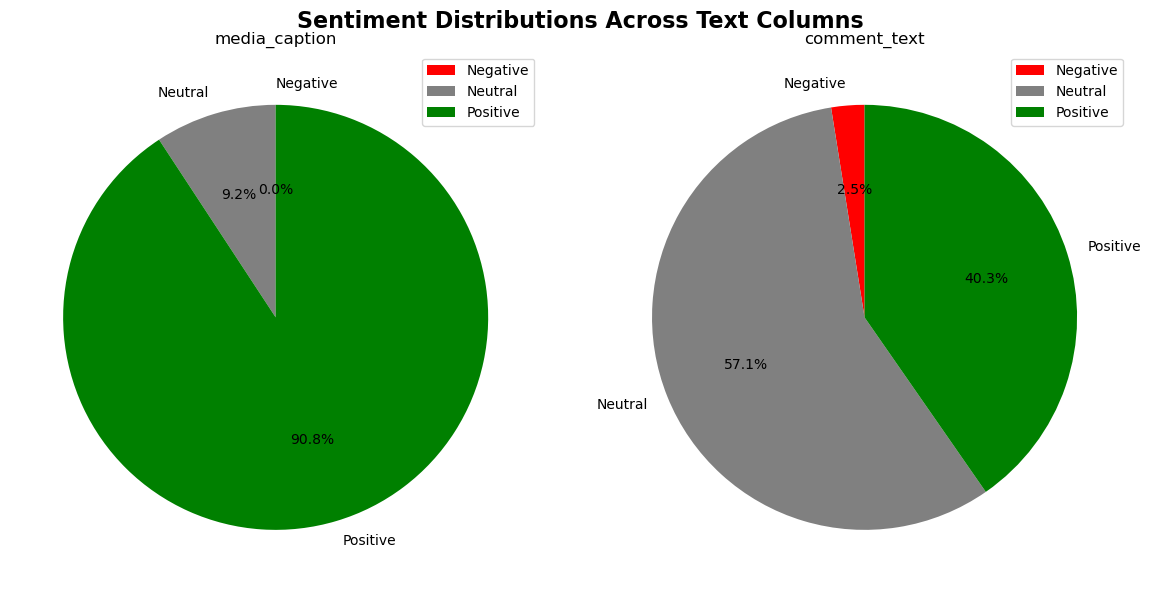

In [129]:
visualize_sentiments (df, text_sentiment_map, sentiment_colors)

# Obtain frequent words for each type of sentiment

### Define a prompt template

In [24]:
prompt_template = PromptTemplate.from_template(
    """Extract the top 10 most important keywords or phrases from the following text, and show how often each one appears. 
Return them in the format: keyword: count, one per line. Only include meaningful content words, not stopwords or punctuation.

Text:
{text}
"""
)

### Collection for Frequent Words and Terms

In [25]:
freq_words_collection = dict()
for text_key in text_sentiment_map.keys():
    #print(text_key, text_sentiment_map[text_key])
    freq_words_collection[text_key] = dict()
        

In [26]:
freq_words_collection

{'media_caption': {}, 'comment_text': {}}

### Call function

In [27]:
freq_words_collection = extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Positive', llm, prompt_template, freq_words_collection)


Top 10 keywords from column 'media_caption' that represent 'Positive' sentiments:
treehut: 12
self-care: 8
shave: 5
routine: 5
skin: 5
collection: 5
nightly: 4
spring break: 4
ultimate: 4
smooth: 3

Top 10 keywords from column 'comment_text' that represent 'Positive' sentiments:
treehut: 33
pr: 27
love: 15
favorite: 8
scent: 7
good: 6
smells: 5
obsessed: 5
products: 5
soft: 4


In [28]:
freq_words_collection = extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Negative', llm, prompt_template, freq_words_collection)


Top 10 keywords from column 'media_caption' that represent 'Negative' sentiments:

Top 10 keywords from column 'comment_text' that represent 'Negative' sentiments:
moroccan rose: 1
scrub: 1
body butter: 1
lotion: 1
perfume: 1
body wash: 1
weird: 1
gross: 1
playdoh: 1
scam: 1


In [29]:
freq_words_collection = extract_frequent_words_for_sentiment (df_orig, text_sentiment_map, 'Neutral', llm, prompt_template, freq_words_collection)


Top 10 keywords from column 'media_caption' that represent 'Neutral' sentiments:
scrubs: 6
Tree Hut: 4
selfcare: 3
video: 3
smooth: 3
shave oils: 2
hydration: 2
irritation: 2
Moroccan Rose: 1
Coco Colada: 1

Top 10 keywords from column 'comment_text' that represent 'Neutral' sentiments:
treehut: 72
pr: 36
buy: 3
smell: 3
walmart: 2
raspberry: 1
ocean: 1
glow: 1
friend: 1
name: 1


### Visualize

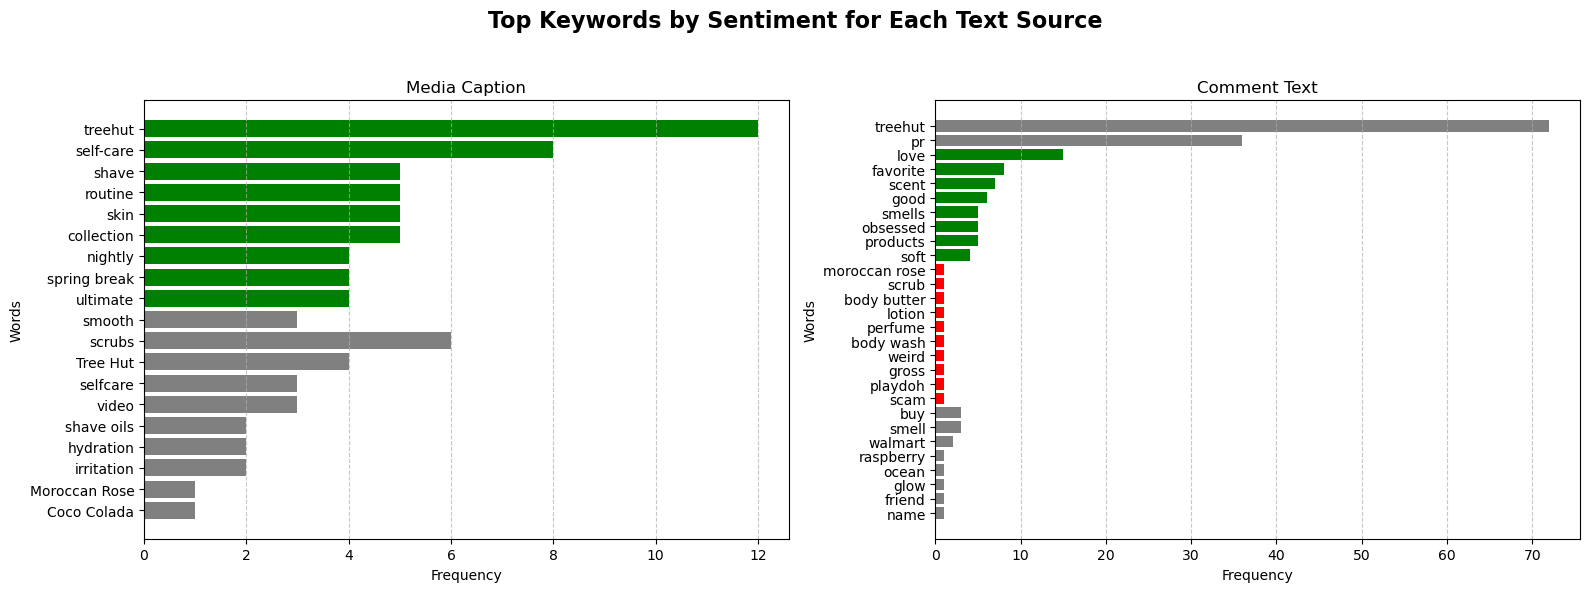

In [72]:
visualize_frequent_words_for_sentiment (freq_words_collection, sentiment_colors)

# Sentiments Trend

In [83]:
df = df_orig.copy()

### Compute Date, Hour, and DayName

In [84]:
df['timestamp'] = df['timestamp'].apply(lambda ts: parser.isoparse(ts))

In [85]:
df['Date'] = df['timestamp'].dt.date
df['Hour'] = df['timestamp'].dt.hour
df['DayName'] = df['timestamp'].dt.day_name()

In [86]:
df

,timestamp,media_id,media_caption,comment_text,sentiment_media_caption,sentiment_comment_text,Date,Hour,DayName
0,2025-03-01 00:13:57.153000+00:00,1090986906404998,"Soft skin, soft life 🩷🌸🫧 get your hands on thi...",I bet this is good,Positive,Positive,2025-03-01,0,Saturday
50,2025-03-01 14:15:19.831000+00:00,1083080453862310,"If you’re seeing this, it’s time to exfoliate ⏰",Megan Brohm hello how are you doing today I ho...,Neutral,Neutral,2025-03-01,14,Saturday
100,2025-03-02 00:56:58.764000+00:00,1091594239677598,*slams laptop shut* ✌️🚿🌴 click the link to get...,Nicole Lee Walmart. I use the nighttime melato...,Positive,Positive,2025-03-02,0,Sunday
150,2025-03-02 22:31:31.547000+00:00,1095789242591431,Freshening up my self-care routine with a new ...,Donika Blaqstallion Anderson this what I use,Positive,Neutral,2025-03-02,22,Sunday
200,2025-03-03 20:29:41.342000+00:00,17842568505433586,Drop a 🪷 if you're obsessed with Lotus Water!,🪷,Positive,Neutral,2025-03-03,20,Monday
...,...,...,...,...,...,...,...,...,...
17600,2025-04-02 15:13:18.667000+00:00,1125861369584218,that's that me espresso,Ash Lee Jorhdan,Neutral,Neutral,2025-04-02,15,Wednesday
17650,2025-04-02 15:55:15.355000+00:00,1125861369584218,that's that me espresso,Ondrea Nordby,Neutral,Neutral,2025-04-02,15,Wednesday
17700,2025-04-02 16:30:53.153000+00:00,1125861369584218,that's that me espresso,Aliyah Skala I need this,Neutral,Neutral,2025-04-02,16,Wednesday
17750,2025-04-02 17:55:39.320000+00:00,1125861369584218,that's that me espresso,Savannah Rose O'Neil okay,Neutral,Neutral,2025-04-02,17,Wednesday


### Visualize Sentiments for Different Text Comments (media_caption, comment_text) as a Function of Date, Hour, and DayName

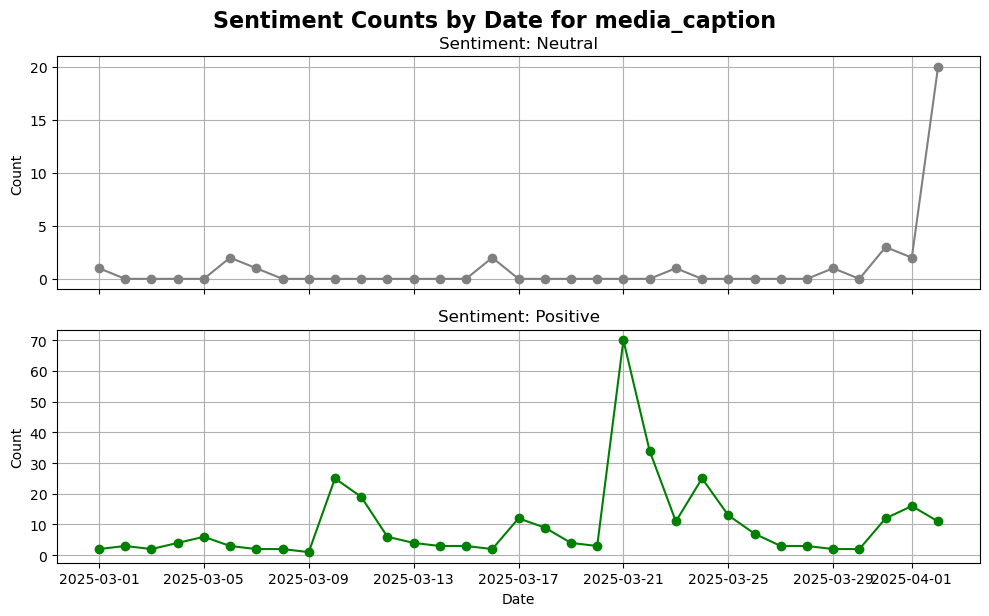

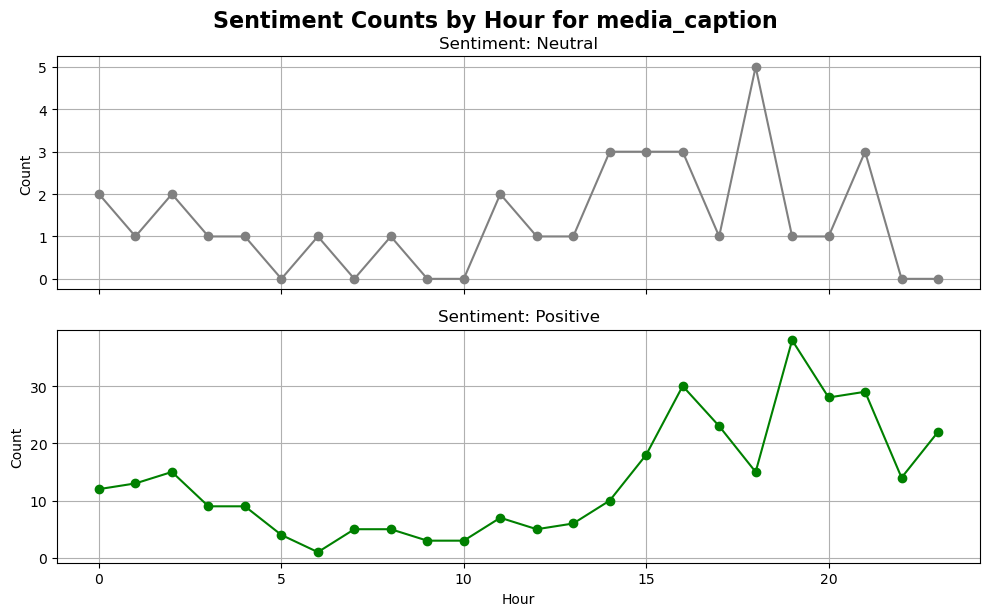

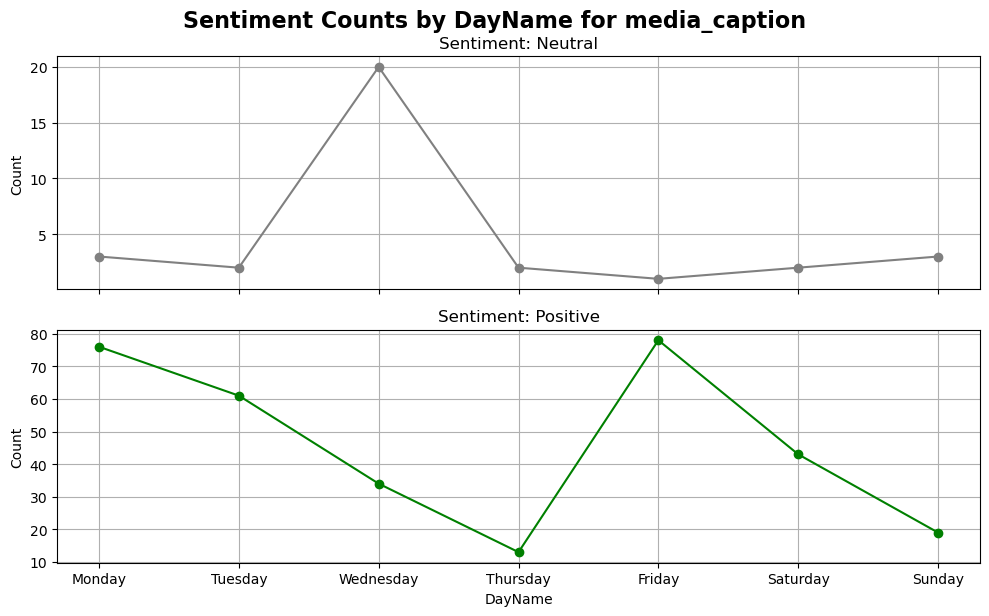

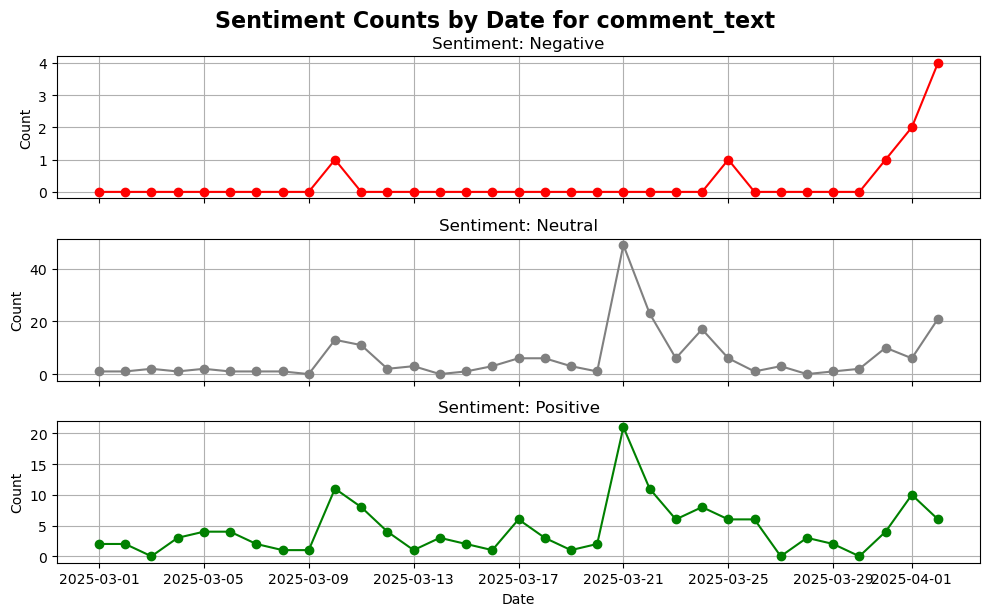

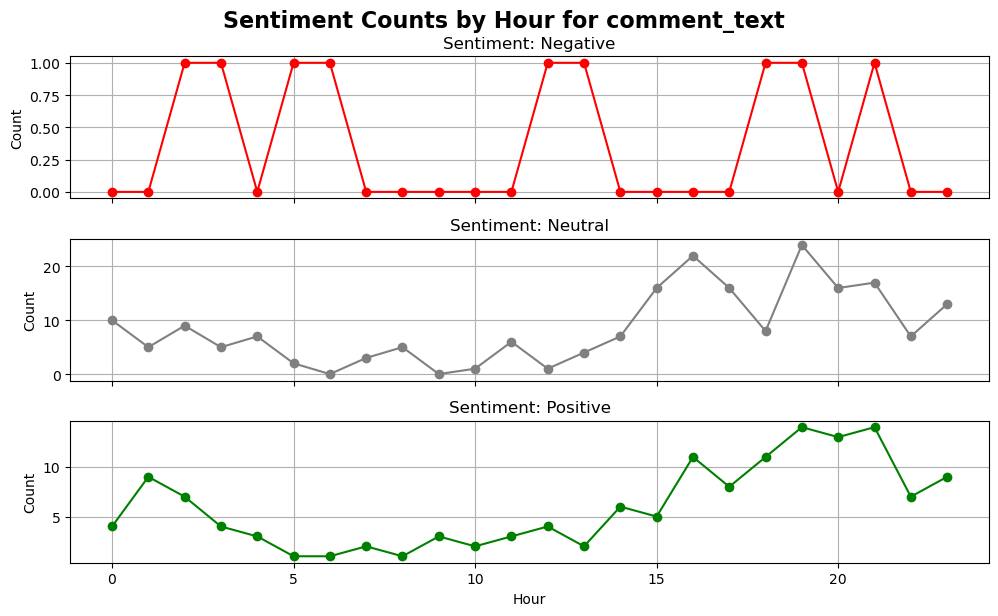

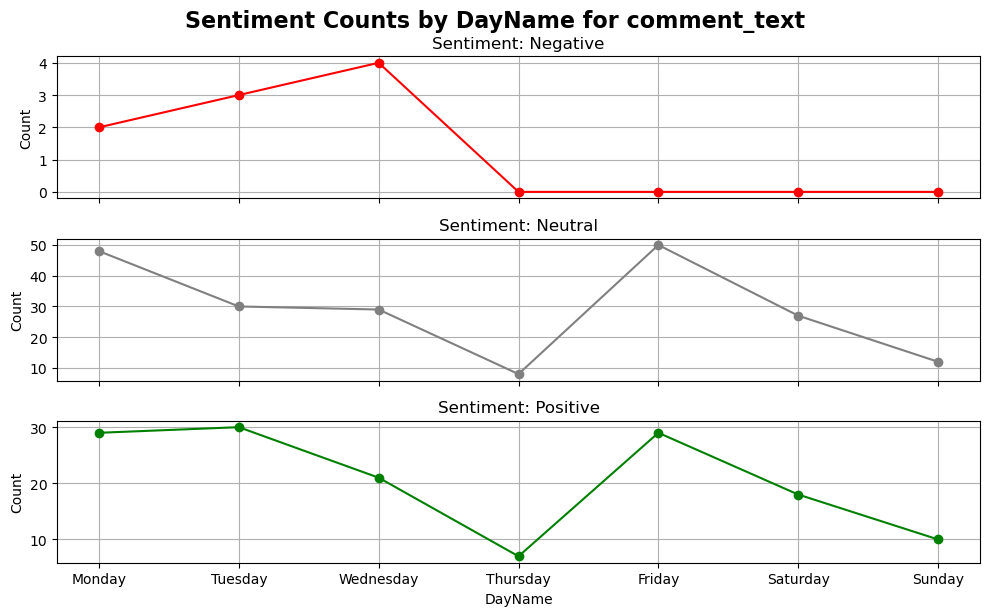

In [130]:
for text_key in text_sentiment_map.keys():
    sentiment_header = text_sentiment_map[text_key]
    for time_type in ['Date', 'Hour', 'DayName']:
        grouped = df.groupby([time_type, sentiment_header]).size().unstack(fill_value=0)
        if time_type == 'DayName':
            grouped = grouped.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        #print(grouped)
        visualize_sentiment_trend (grouped, time_type, text_key, sentiment_colors)
        